# Notebook demonstrating the use of Timeseriesai for generating predictions
https://github.com/timeseriesAI/timeseriesAI

## The below is done using the tutorial data set (one state, one season) and is a very small dataset so the results are only intended for use on how to use this, not necessarily what the ML capability is

### uses env timeseriesai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/scottcha/src/timeseriesAI')
from tsai.all import *
package_versions()
hardware_details()

tsai       : 0.1.0
fastai2    : 0.0.26
fastcore   : 0.1.30
torch      : 1.6.0
scipy      : 1.5.2
numpy      : 1.19.1
pandas     : 1.1.0
Total RAM  :  47.07 GB
Used RAM   :   2.50 GB
n_cpus     : 16
device     : cuda (GeForce GTX 1080 Ti)


In [3]:
from joblib import Parallel, delayed

In [12]:
#data_root = '/media/scottcha/E1/Data/OAPMLData/'
data_root = '/media/scottcha/E1/Data/Temp/Tutorial/'
ml_path = data_root + '/5.MLData/'
num_features = 978
interpolation = 1

In [5]:
def calculate_feature_mean(feature):
    print('On feature: ' + str(feature))
    return np.nanmean(X[0:100000,feature,:])

In [6]:
def calculate_feature_std(feature):
    print('On feature: ' + str(feature))
    return np.nanstd(X[0:100000,feature,:])

In [7]:
#load the X train data from numpy as memmapped file
X = np.load(ml_path + '/Xtrain_batch_0_on_disk.npy', mmap_mode='r')

In [10]:
#if we don't have cached versions of these we need to calcualte this for the feature
#standardization, this takes awhile and requires a lot of memory so I only do it on a subset
#of the data (first 100000 rows)
feature_means = Parallel(n_jobs=4)(map(delayed(calculate_feature_mean), range(0,num_features)))

In [11]:
feature_std = Parallel(n_jobs=4)(map(delayed(calculate_feature_std), range(0,num_features)))

In [13]:
#cache the values
np.save(ml_path + '/feature_means_interpolation' + str(interpolation) +  'x.npy', np.asarray(feature_means))

In [14]:
np.save(ml_path + '/feature_std_interpolation' + str(interpolation) +  'x.npy', np.asarray(feature_std))

In [15]:
#load the values
feature_means = np.load(ml_path + '/feature_means_interpolation1x.npy')

In [59]:
feature_means[:10]

array([1.05811290e-04, 1.31527035e-04, 8.15083185e-05, 1.08188331e-04,
       1.20382414e-04, 9.62946579e-05, 9.11722527e-05, 9.93621870e-05,
       8.34299353e-05, 1.11554895e-04], dtype=float32)

In [17]:
feature_std = np.load(ml_path + '/feature_std_interpolation1x.npy')

In [58]:
feature_std[:10]

array([3.35816985e-05, 4.23320053e-05, 3.76113967e-05, 1.31853885e-05,
       1.69262348e-05, 1.50744563e-05, 1.55597354e-05, 1.60028212e-05,
       1.68602237e-05, 2.21242681e-05], dtype=float32)

In [19]:
#load the full X datafile which has both Train and Test concated
X = np.load(ml_path + '/X_all.npy', mmap_mode='r')

In [20]:
#read in the corresponding label files and concat them
#can get the right values here based on the contents of hte ml_path directory
num_y_batches = 1
num_y_train_files_per_batch = 20
num_y_test_batches = 1
num_y_test_files_per_batch = 1


y_df = None
for i in range(0, num_y_batches):
    for j in range(0, num_y_train_files_per_batch):
        df = pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + str(j) + '.0.parquet')  
        y_df = pd.concat([y_df, df])

for i in range(0, num_y_test_batches):
    for j in range(0, num_y_test_files_per_batch):
        df = pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + str(j) + '.0.parquet')  
        y_df = pd.concat([y_df, df])

In [21]:
y_df['season'].value_counts()

15-16    10500
Name: season, dtype: int64

In [22]:
#cache the labels 
pickle.dump( y_df, open( ml_path + 'y_df.p', 'wb' ) )

In [23]:
y_df = pickle.load( open( ml_path + 'y_df.p', 'rb' ) )

In [24]:
y_df.shape

(10500, 304)

In [25]:
X.shape

(10500, 978, 180)

In [26]:
y_df['Day1DangerAboveTreeline'].value_counts()

Low             2715
Moderate        2714
Considerable    2571
High            2500
Name: Day1DangerAboveTreeline, dtype: int64

In [27]:
y_df['Day1DangerAboveTreeline'].value_counts()

Low             2715
Moderate        2714
Considerable    2571
High            2500
Name: Day1DangerAboveTreeline, dtype: int64

In [28]:
#convert the labels to encoded values
y_df['Day1AboveCat'] = y_df['Day1DangerAboveTreeline'].astype('category')
y = y_df['Day1AboveCat'].cat.codes.values

In [29]:
y_df['Day1AboveCat']

0      Considerable
1      Considerable
2      Considerable
3          Moderate
4              High
           ...     
495        Moderate
496        Moderate
497        Moderate
498        Moderate
499        Moderate
Name: Day1AboveCat, Length: 10500, dtype: category
Categories (4, object): ['Considerable', 'High', 'Low', 'Moderate']

In [30]:
y_df['Day1AboveCat'].cat.codes.head()

0    0
1    0
2    0
3    3
4    1
dtype: int8

In [31]:
y.shape

(10500,)

In [32]:
#X_size=25000

In [33]:
#index file which indicates which rows in X are train or test
#be carful these don't overlap
train_test_split = 10000
#can use a smaller train subset to make development faster
splits_2 = (L([i for i in range(0,train_test_split)]), L([i for i in range(train_test_split,train_test_split+500)]))

In [34]:
splits_2

((#10000) [0,1,2,3,4,5,6,7,8,9...],
 (#500) [10000,10001,10002,10003,10004,10005,10006,10007,10008,10009...])

In [35]:
#load and check the means and std deviations
feature_means = (np.nan_to_num(feature_means))

In [36]:
np.isnan(feature_means).any()

False

In [37]:
feature_std = (np.nan_to_num(feature_std, nan=1.0))

In [38]:
np.isnan(feature_std).any()

False

In [39]:
#method to standardize each batch while also replacing any nans with the mean value before standarization
class TSStandardizeNanMeanReplaceNan(Transform):
    "Standardize/destd batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 99
    def __init__(self, mean=None, std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
            x, *_ = dl.one_batch()
            x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)):
        fill_values = torch.zeros_like(x)
        std_values = torch.zeros_like(x)       
        for i in range(0,x.shape[1]):
            fill_values[:,i,:] = torch.full_like(x[:,i,:], feature_means[i])
            std_values[:,i,:] = torch.full_like(x[:,i,:], feature_std[i])
        
        x = torch.where(torch.isnan(x), fill_values, x)
       
        if self.by_sample:        
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            
        t = (x - fill_values) / std_values
        del fill_values, std_values
        return torch.where(torch.isnan(t), torch.zeros_like(t), t)

In [40]:
X.shape

(10500, 978, 180)

In [41]:
#create the dataset
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)

In [42]:
X[0]

memmap([[           nan,            nan,            nan, ...,
         9.29999951e-05, 1.10142857e-04, 1.06857144e-04],
        [           nan,            nan,            nan, ...,
         9.99999975e-05, 1.17000003e-04, 1.21999998e-04],
        [           nan,            nan,            nan, ...,
         8.79999861e-05, 1.01999998e-04, 9.60000034e-05],
        ...,
        [           nan,            nan,            nan, ...,
         1.19599998e-01, 1.19599998e-01, 1.19599998e-01],
        [           nan,            nan,            nan, ...,
         1.19599998e-01, 1.19599998e-01, 1.19599998e-01],
        [           nan,            nan,            nan, ...,
         1.19599998e-01, 1.19599998e-01, 1.19599998e-01]], dtype=float32)

/home/scottcha/src/fastai2/fastai2/torch_core.py:106: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(x)


<AxesSubplot:title={'center':'3'}>

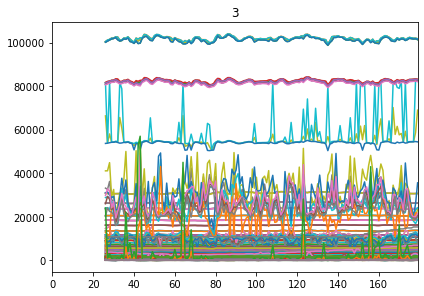

In [43]:
#check on set
show_at(dsets.valid, 6)

In [44]:
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[128], batch_tfms=[TSStandardizeNanMeanReplaceNan()], num_workers=0)

In [45]:
#check both the train and test sets to ensure that there aren't full rows with all nulls

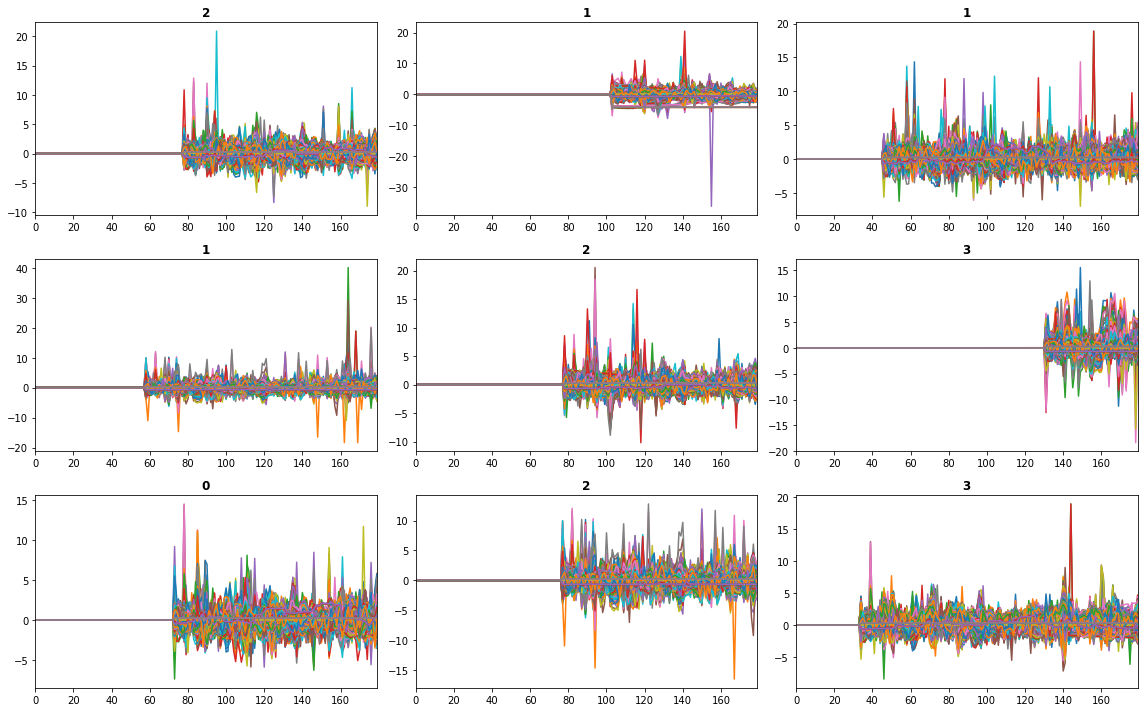

In [46]:
dls.show_batch()

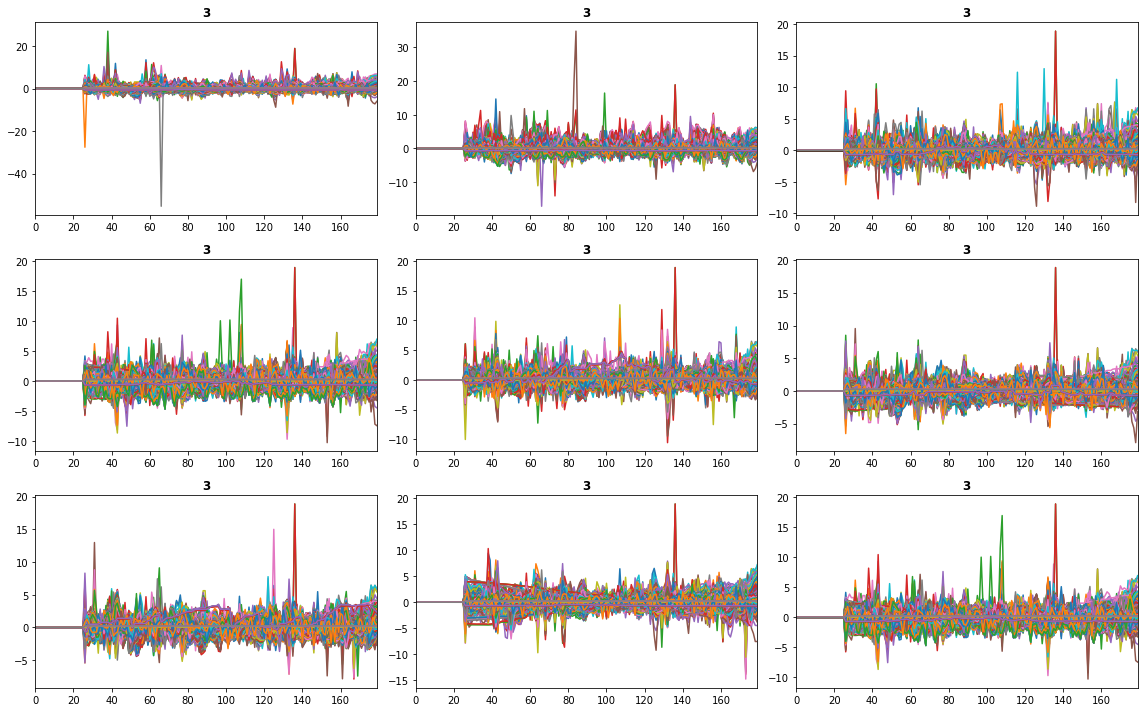

In [47]:
dls.valid.show_batch()

In [48]:
dls.c

4

In [49]:
dls.vars

978

# Lets try and train a model, in the tutorial case we are using an extremely small dataset so no conclusions should be drawn from these results they are for illustrative purposes only

In [50]:
model = InceptionTime(dls.vars, dls.c)
matcor = MatthewsCorrCoef()

learn = Learner(dls, model, metrics=[matcor, accuracy], callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=5)])
learn.save('stage0')

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.019054606556892395)

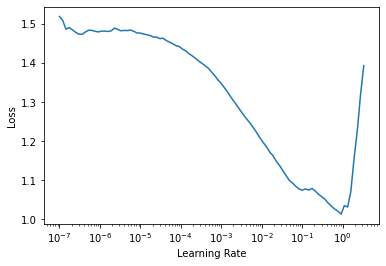

In [52]:
learn.load('stage0')
learn.lr_find()

In [53]:
learn.fit_one_cycle(3, lr_max=1e-2)
learn.save('stage1')

epoch,train_loss,valid_loss,matthews_corrcoef,accuracy,time
0,0.644853,3.641522,0.233980,0.340000,00:18
1,0.317006,5.755499,-0.023607,0.224000,00:15
2,0.154209,7.027813,0.065542,0.202000,00:15


### Results
1. looking at the metrics above it seems to be overfitting after epoch 1
2. Looking at the confusion matrix we can see that its ok at distinquishing between 0/1 & 2/3 

Possibilities:
2. There may be features which are causing the overfitting


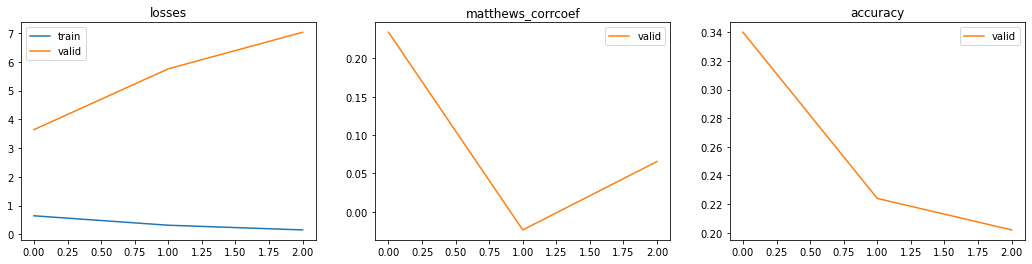

In [54]:
learn.recorder.plot_metrics()

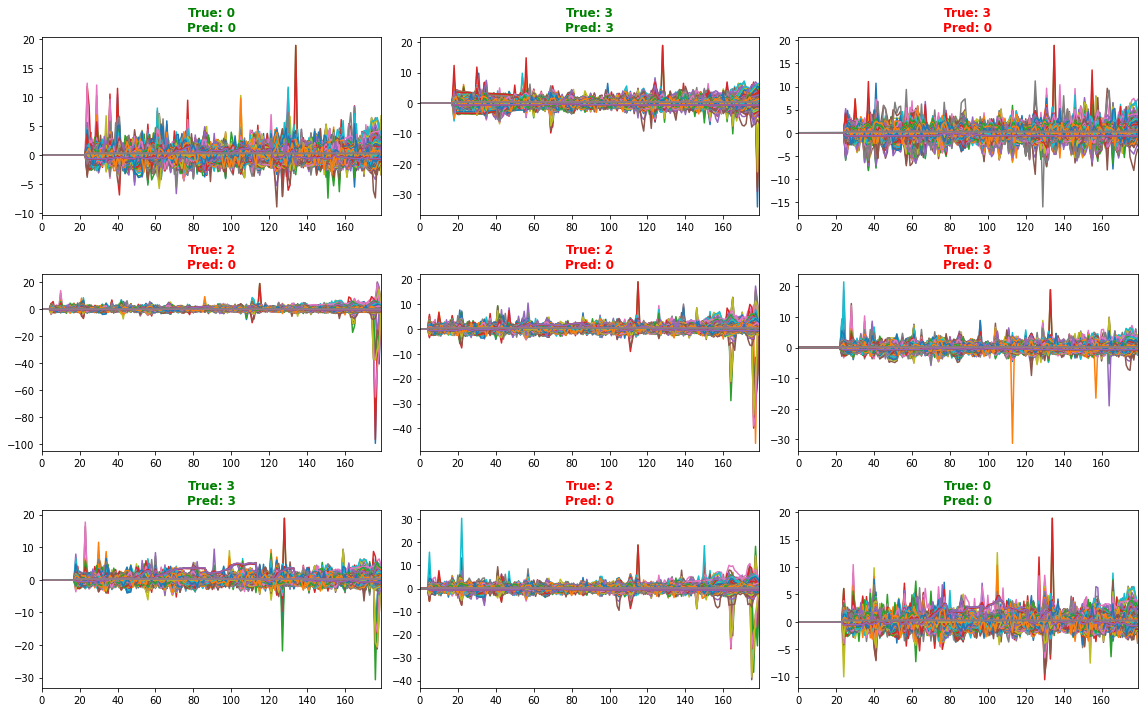

In [55]:
learn.show_results()

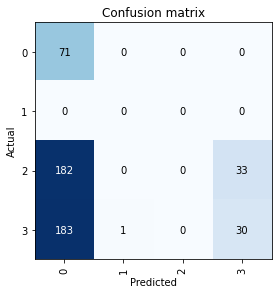

In [56]:
#confustion matrix, not very good, more work to do . . .
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()